# County Mapper

This notebook includes code to make geopandas plots of California energy data. These plots mostly consist of choropleth maps showing various measurements by county but there are also solar plant and wind farm maps as well.

In [1]:
import geopandas
from shapely.geometry import Polygon, MultiPolygon, MultiPoint
import pandas as pd
from urllib.request import urlopen
import json
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import numpy as np

### Load and organize California county outline coordinates

In [16]:
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

In [17]:
ca_county_features = []

for i in range(len(counties['features'])):
    if counties['features'][i]['id'][0:2] == '06':
        ca_county_features.append(counties['features'][i])

#### Define color mapping function

In [61]:
def rgb_calc(minn,maxx,val):
    scaled = (val-minn)/(maxx-minn)
    if scaled <= 0.25:
        return [1,4*scaled,0]
    if scaled > 0.25 and scaled <= 0.5:
        return [(-4)*scaled+2,1,0]
    if scaled > 0.5 and scaled <= 0.75:
        return [0,1,4*scaled-2]
    if scaled > 0.75:
        return [0,(-4)*scaled+4,1]
    else:
        return [0,0,0]

### Define function to make shapely polygons

In [18]:
def mk_poly(coords):
    verts = []
    for pair in coords:
        verts.append(tuple(pair))
    return Polygon(verts)

### Make a list of county polygons

In [19]:
names = []
poly_list = []
for i in range(len(ca_county_features)):
    if len(ca_county_features[i]['geometry']['coordinates']) > 1:
        nu_poly = []
        for j in range(len(ca_county_features[i]['geometry']['coordinates'])):
            sub_poly = mk_poly(ca_county_features[i]['geometry']['coordinates'][j][0])
            nu_poly.append(sub_poly)
        nu_poly = MultiPolygon(nu_poly)
        names.append(ca_county_features[i]['properties']['NAME'])
    elif len(ca_county_features[i]['geometry']['coordinates'][0]) == 1:
        nu_poly = mk_poly(ca_county_features[i]['geometry']['coordinates'][0][0])
        names.append(ca_county_features[i]['properties']['NAME'])
    else:
        nu_poly = mk_poly(ca_county_features[i]['geometry']['coordinates'][0])
        names.append(ca_county_features[i]['properties']['NAME'])
    poly_list.append(nu_poly)

### Make dataframe of county polygons

In [20]:
df = pd.DataFrame({'name':names,'geometry':poly_list})
df.head(2)

,name,geometry
0,Amador,"POLYGON ((-120.995497 38.225405, -121.027084 3..."
1,Glenn,"POLYGON ((-122.937654 39.798156, -122.046471 3..."


In [21]:
county = geopandas.GeoDataFrame(df,geometry='geometry')

### merge with data

In [22]:
county = county.sort_values('name')
county['name'] = county['name'].str.lower()
ind = list(range(58))
county['ind'] = ind
county.set_index('ind',inplace=True)
county.head(2)

,name,geometry
ind,,
0,alameda,"POLYGON ((-121.85576 37.48454, -122.04527 37.4..."
1,alpine,"POLYGON ((-120.07239 38.70277, -119.88030 38.8..."


### Readin in elecricity usage data

In [26]:
cons = pd.read_csv('../datasets/map_data/ElectricityByCounty.csv')
cons.head(2)

,County,Sector,2018,Total Usage
0,ALAMEDA,Total,10417.109747,10417.109747
1,ALPINE,Total,18.704208,18.704208


In [27]:
cons = cons.sort_values('County')
cons['County'] = cons['County'].str.lower()
cons.rename(columns={'County':'name'},inplace=True)
cons.drop(columns = ['Sector','2018'],inplace=True)
cons.head(2)

,name,Total Usage
0,alameda,10417.109747
1,alpine,18.704208


In [28]:
county = county.merge(cons,on='name')
county['Log Usage'] = np.log(county['Total Usage'])
county.head(2)

,name,geometry,Total Usage,Log Usage
0,alameda,"POLYGON ((-121.85576 37.48454, -122.04527 37.4...",10417.109747,9.251205
1,alpine,"POLYGON ((-120.07239 38.70277, -119.88030 38.8...",18.704208,2.928749


### Make function to plot map data

In [29]:
def county_plot(gdf,colname,color):
    fig, ax = plt.subplots(1, 1,figsize=(10,10))
    plt.title(colname,fontsize=24)
    plt.xlabel('Longitude',fontsize=18)
    plt.ylabel('Latitude',fontsize=18)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    gdf.plot(column=colname, ax=ax, legend=True, cax=cax, cmap=color,edgecolor='black')

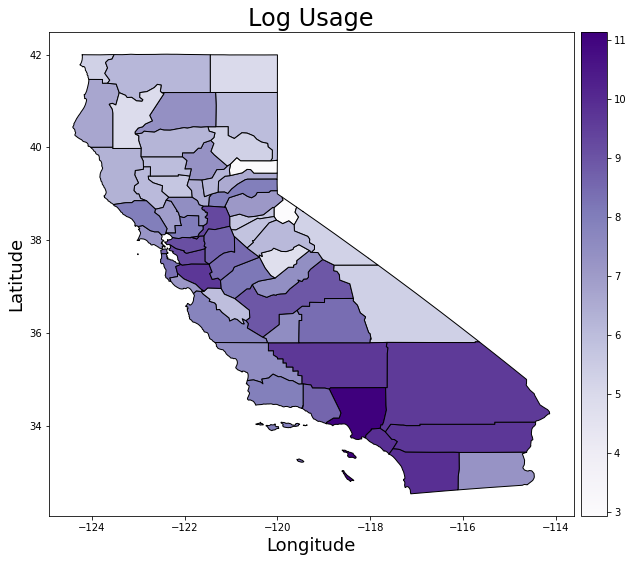

In [30]:
county_plot(county,'Log Usage','Purples')
#plt.savefig('./images/log_usage.png',dpi=235,bbox_inches='tight');

### Readin population data and merge

In [34]:
pop = pd.read_csv('../datasets/map_data/county_census.csv')
pop.head(2)

,CTYNAME,Pop,GrowthRate
0,Los Angeles County,10105518,2.8820
1,San Diego County,3343364,7.7356


In [35]:
pop.rename(columns={'CTYNAME':'name'},inplace=True)
pop['name'] = pop['name'].str.replace(' County','').str.lower()
pop.head(2)

,name,Pop,GrowthRate
0,los angeles,10105518,2.8820
1,san diego,3343364,7.7356


In [36]:
county = county.merge(pop,on='name')
county.head(2)

,name,geometry,Total Usage,Log Usage,Pop,GrowthRate
0,alameda,"POLYGON ((-121.85576 37.48454, -122.04527 37.4...",10417.109747,9.251205,1666753,10.159
1,alpine,"POLYGON ((-120.07239 38.70277, -119.88030 38.8...",18.704208,2.928749,1101,-5.168


In [37]:
county['Per Capita Usage'] = county['Total Usage']/county['Pop']

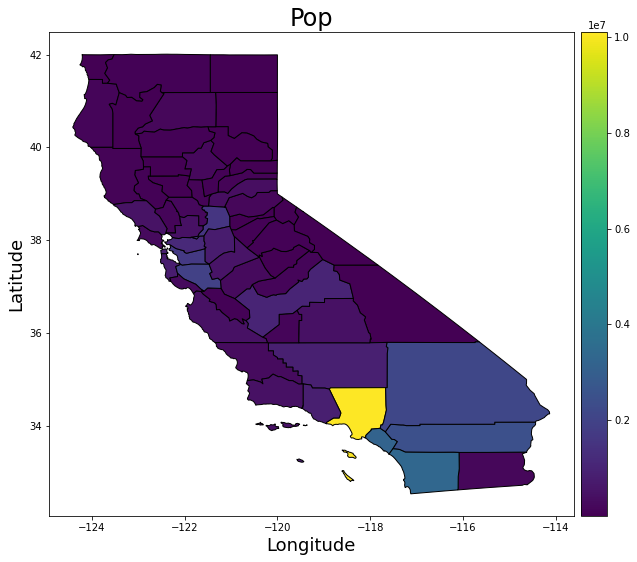

In [38]:
county_plot(county,'Pop','viridis')

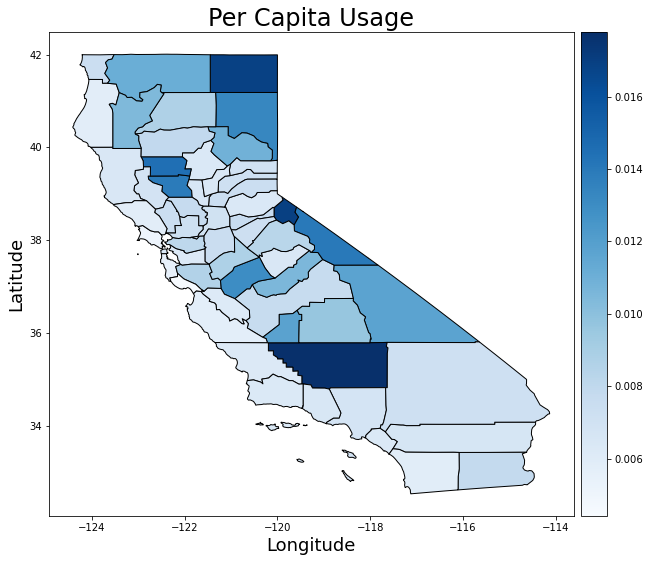

In [39]:
county_plot(county,'Per Capita Usage','Blues')
# plt.savefig('./images/pc_usage.png',dpi=235,bbox_inches='tight');

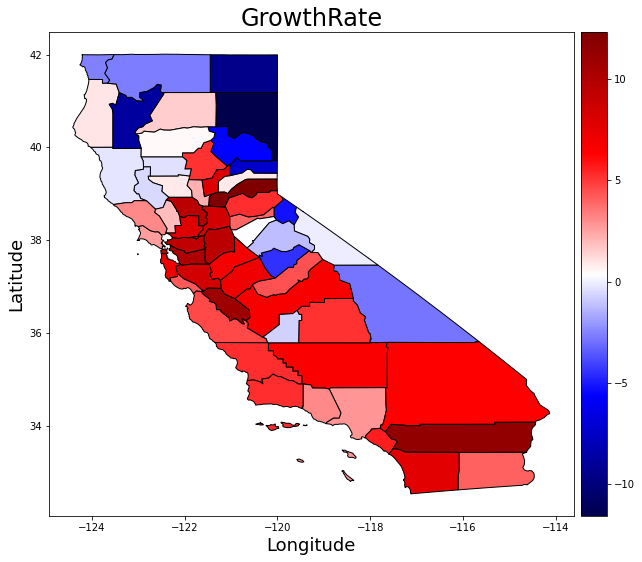

In [40]:
county_plot(county,'GrowthRate','seismic')
#plt.savefig('./images/growth.png',dpi=235,bbox_inches='tight');

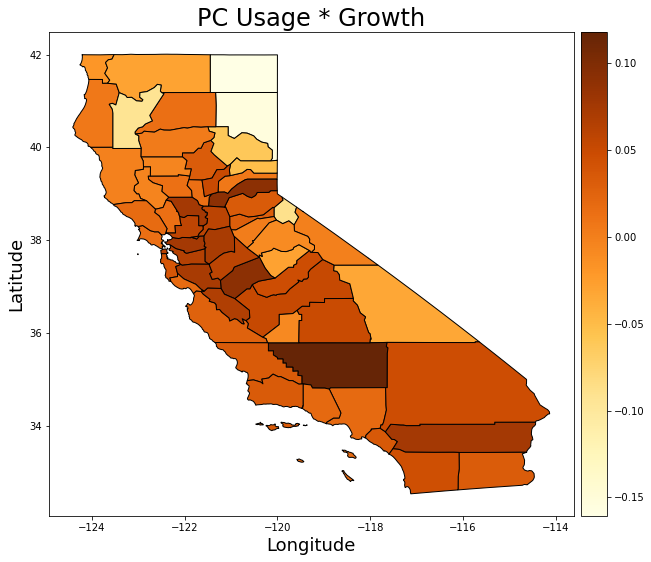

In [41]:
county['PC Usage * Growth'] = county['Per Capita Usage'] * county['GrowthRate']
county_plot(county,'PC Usage * Growth','YlOrBr')
#plt.savefig('./images/pc_usage-growth.png',dpi=235,bbox_inches='tight');

### Add in powerplant data

In [43]:
gen = pd.read_csv('../datasets/California_Power_Plants.csv')
gen['name'] = gen['County'].str.lower()

In [44]:
active = gen[gen['Status']=='Operating']

In [45]:
county = county.merge(active.groupby('name')['MW'].sum(),on='name',how='left')
county.head(2)

,name,geometry,Total Usage,Log Usage,Pop,GrowthRate,Per Capita Usage,PC Usage * Growth,MW
0,alameda,"POLYGON ((-121.85576 37.48454, -122.04527 37.4...",10417.109747,9.251205,1666753,10.159,0.006250,0.063493,1494.395
1,alpine,"POLYGON ((-120.07239 38.70277, -119.88030 38.8...",18.704208,2.928749,1101,-5.168,0.016988,-0.087796,7.150


In [46]:
county['Total Production'] = county['MW'].fillna(0)
county.drop(columns='MW',inplace=True)

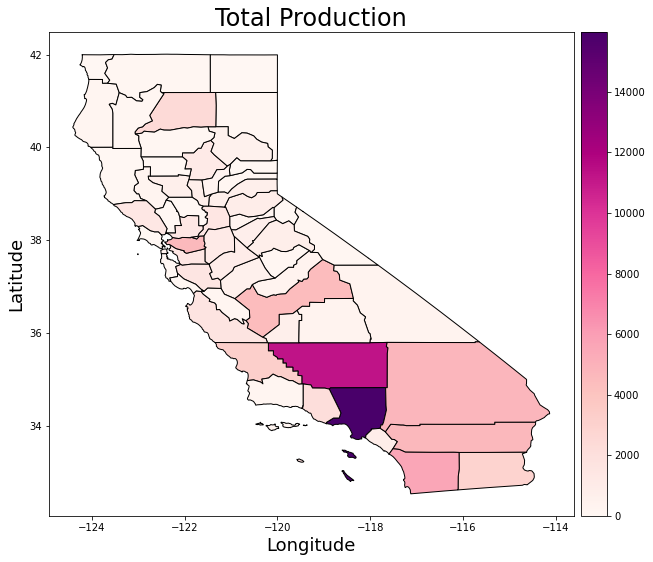

In [47]:
county['PC Usage * Growth'] = county['Per Capita Usage'] * county['GrowthRate']
county_plot(county,'Total Production','RdPu')
#plt.savefig('./images/total_production.png',dpi=235,bbox_inches='tight');

### Add solar data to gdf

In [48]:
solar = gen[(gen['General_Fuel']=='Solar') & (gen['Status']=='Operating') & (gen['State_']=='CA')]

In [49]:
county = county.merge(solar.groupby('name')['MW'].sum(),on='name',how='left')
county.head(2)

,name,geometry,Total Usage,Log Usage,Pop,GrowthRate,Per Capita Usage,PC Usage * Growth,Total Production,MW
0,alameda,"POLYGON ((-121.85576 37.48454, -122.04527 37.4...",10417.109747,9.251205,1666753,10.159,0.006250,0.063493,1494.395,18.8
1,alpine,"POLYGON ((-120.07239 38.70277, -119.88030 38.8...",18.704208,2.928749,1101,-5.168,0.016988,-0.087796,7.150,NaN


In [50]:
county['Solar'] = county['MW'].fillna(0)

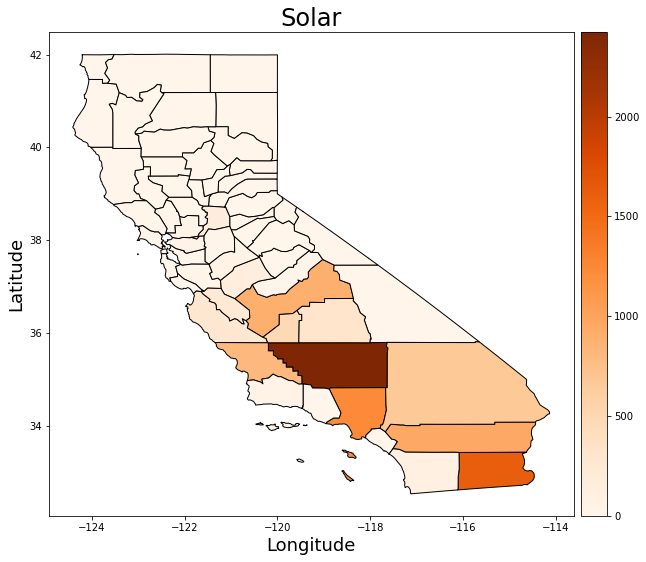

In [51]:
fig, ax = plt.subplots(1, 1,figsize=(10,10))
plt.title('Solar',fontsize=24)
plt.xlabel('Longitude',fontsize=18)
plt.ylabel('Latitude',fontsize=18)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
county.plot(column='Solar', ax=ax, legend=True, cax=cax, cmap='Oranges',edgecolor='black');

## Add clusters to this ^^^

In [136]:
solar_clusters = pd.read_csv('../datasets/main_solar.csv')
solar_cluster_centroids = pd.read_csv('../datasets/solar_clusters.csv')

In [137]:
def make_multipoint(data,cluster):
    target = data[data['cluster']==cluster]
    pairs = list(zip(target['Longitude'],target['Latitude']))
    geom = MultiPoint(pairs)
    return geom

In [138]:
no_clusters = 30

clu = []
geo = []
color= []

for c in range(no_clusters):
    cl = make_multipoint(solar_clusters,c)
    clu.append(c)
    geo.append(cl)
    color.append(rgb_calc(1,no_clusters,c+1))

solar_cluster_df = pd.DataFrame({'cluster':clu,'geometry':geo,'color':color})
solar_cluster_gdf = geopandas.GeoDataFrame(solar_cluster_df,geometry='geometry')

#solar_centroids = MultiPoint(list(zip(solar_cluster_centroids['Longitude'],solar_cluster_centroids['Latitude'])))
#solar_centroids_df = pd.DataFrame({'name':'centroids','geometry':solar_centroids})
#solar_centroids_gdf = geopandas.GeoDataFrame(solar_centroids,geometry='geometry')

/Users/Sam/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/plotting.py:508: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


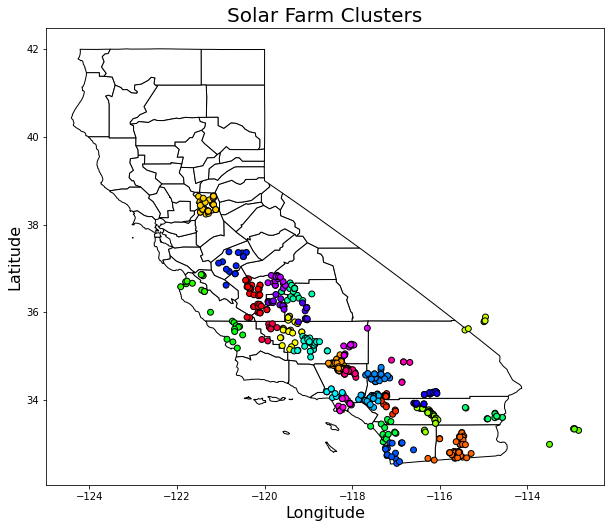

In [140]:
base = county.plot(column='Solar',figsize=(10,10),color='white',edgecolor='black')
solar_cluster_gdf.plot(ax=base,marker='o', markersize=35,column='cluster',cmap='hsv',edgecolor='k',label='cluster')

plt.title('Solar Farm Clusters',fontsize=20)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16);
#plt.savefig('../images/solar_clusters.png',dpi=235,bbox_inches='tight');

### Wind Clusters

In [122]:
wind_clusters = pd.read_csv('../datasets/main_solar.csv')

no_clusters = 7

clu = []
geo = []
color= []

for c in range(no_clusters):
    cl = make_multipoint(wind_clusters,c)
    clu.append(c)
    geo.append(cl)
    color.append(rgb_calc(1,no_clusters,c+1))

df = pd.DataFrame({'cluster':clu,'geometry':geo,'color':color})
gdf = geopandas.GeoDataFrame(df,geometry='geometry')

In [123]:
wind_clusters.shape

(671, 58)

/Users/Sam/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/plotting.py:508: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


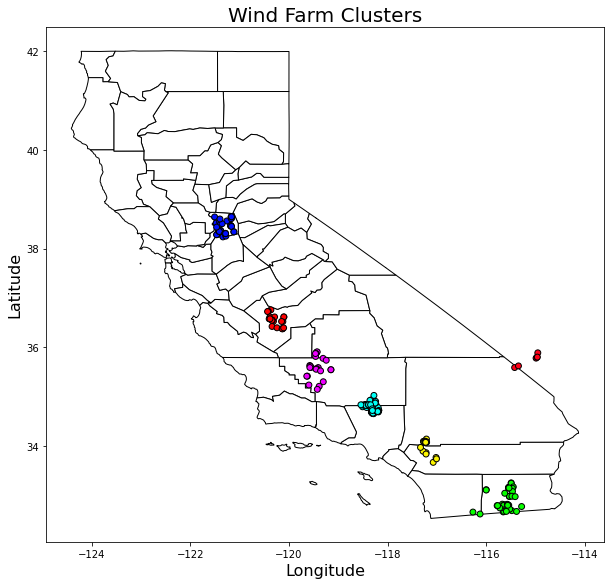

In [124]:
base = county.plot(column='Solar',figsize=(10,10),color='white',edgecolor='black')
gdf.plot(ax=base,marker='o', markersize=35,column='cluster',cmap='hsv',edgecolor='k',label='cluster')
plt.title('Wind Farm Clusters',fontsize=20)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16);
plt.savefig('../images/wind_clusters.png',dpi=235,bbox_inches='tight');

### Save data to file

In [113]:
county.to_file("datasets/county_agg.geojson", driver='GeoJSON')